In [1]:
# this code is generated by the Domino Code Assist toolbar button
import domino_code_assist as dca
dca.init()

Cannot show ipywidgets in text

In [2]:
import zipfile

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import pandas as pd
from lightgbm import LGBMClassifier

In [3]:
import os
from copy import copy
from itertools import product
import pprint
import shutil
import time
from typing import Dict

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

In [4]:
# create an experiment in MLflow

# we'll make the name unique in the project by appending a timestamp so that you and other users can run this cell more than once.
timestamp = time.time()
username = os.environ['DOMINO_STARTING_USERNAME']
experiment_name = f"census-classifier-{timestamp}"
# below, we'll use the returned experiment_id in calls to mlflow.start_run() to add data to the experiment.
experiment_id = mlflow.create_experiment(experiment_name)
print(f"Experiment id: {experiment_id}")
print(f"Experiment name: {experiment_name}")

Experiment id: 3
Experiment name: census-classifier-1688007203.314443


In [5]:
!pip install raiutils

from raiutils.dataset import fetch_dataset
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', LGBMClassifier(random_state=0))])

    return pipeline

outdirname = 'responsibleai.12.28.21'
zipfilename = outdirname + '.zip'

fetch_dataset('https://publictestdatasets.blob.core.windows.net/data/' + zipfilename, zipfilename)

with zipfile.ZipFile(zipfilename, 'r') as unzip:
    unzip.extractall('.')

target_feature = 'income'
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'gender', 'native-country']


train_data = pd.read_csv('adult-train.csv', skipinitialspace=True)
test_data = pd.read_csv('adult-test.csv', skipinitialspace=True)

X_train_original, y_train = split_label(train_data, target_feature)
X_test_original, y_test = split_label(test_data, target_feature)

pipeline = create_classification_pipeline(X_train_original)

y_train = y_train[target_feature].to_numpy()
y_test = y_test[target_feature].to_numpy()


# Take 500 samples from the test data
test_data_sample = test_data.sample(n=500, random_state=5)

Dataset download attempt 1 of 4


/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


model signature: inputs: 
  ['age': long, 'workclass': string, 'fnlwgt': long, 'education': string, 'education-num': long, 'marital-status': string, 'occupation': string, 'relationship': string, 'race': string, 'gender': string, 'capital-gain': long, 'capital-loss': long, 'hours-per-week': long, 'native-country': string]
outputs: 
  [Tensor('object', (-1,))]

Finished predictions.
Run: skillful-sheep-656

Classification report:
              precision    recall  f1-score   support

       <=50K      0.899     0.943     0.920     12435
        >50K      0.780     0.656     0.713      3846

    accuracy                          0.875     16281
   macro avg      0.839     0.799     0.816     16281
weighted avg      0.870     0.875     0.871     16281




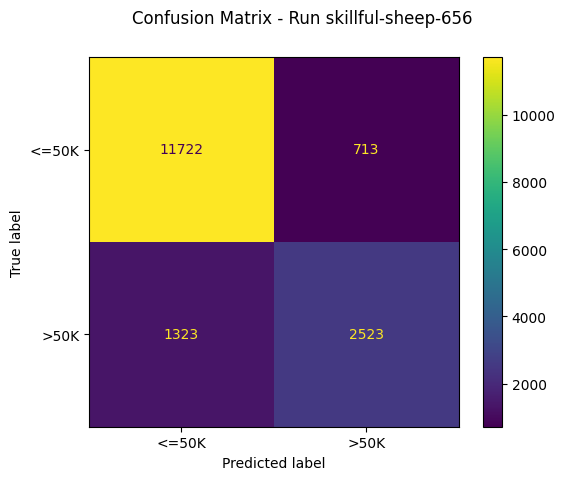

Recording run params, metrics, and artifacts to MLflow...
{'<=50K': {'precision': 0.8985818321195861, 'recall': 0.9426618415761963, 'f1-score': 0.920094191522763, 'support': 12435}, '>50K': {'precision': 0.7796662546353523, 'recall': 0.65600624024961, 'f1-score': 0.7125105902287491, 'support': 3846}, 'accuracy': 0.8749462563724587, 'macro avg': {'precision': 0.8391240433774692, 'recall': 0.799334040912903, 'f1-score': 0.8163023908757561, 'support': 16281}, 'weighted avg': {'precision': 0.8704908480888532, 'recall': 0.8749462563724587, 'f1-score': 0.8710574904247483, 'support': 16281}}


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [8]:
from mlflow.models.signature import infer_signature

run_name=None
with mlflow.start_run(experiment_id=experiment_id, run_name=None) as run:
    if run_name is None:
        run_name = run.info.run_name
            
    model = pipeline.fit(X_train_original, y_train)

    # Testing
    predicted = model.predict(X_test_original)
    prediction_report_str = metrics.classification_report(y_test, predicted, digits=3, output_dict=False)
    prediction_report_dict = metrics.classification_report(y_test, predicted, output_dict=True)
    
    signature = infer_signature(X_test_original, predicted)
    print(f"model signature: {signature}")
    
    # print some info about the run and also save as file for an MLflow artifact
    print("Finished predictions.")
    run_overview = (
            f"Run: {run_name}\n"            
            "\n"
            "Classification report:\n"
            f"{prediction_report_str}\n"
    )
    print(f"{run_overview}")
    run_overview_file_name = "run_overview.txt"
    with open(run_overview_file_name, "w") as f:
        f.write(run_overview)
    
    # visualize model performance and save visualization for an MLflow artifact
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
    disp.figure_.suptitle(f"Confusion Matrix - Run {run_name}")
    confusion_matrix_file_name = f"confusion_matrix_run_{run_name}.png"
    plt.savefig(confusion_matrix_file_name)
    plt.show()

    print("Recording run params, metrics, and artifacts to MLflow...")
    # record notable sklearn model params and performance metrics.

    print(prediction_report_dict)
    for metric in ("precision", "recall", "f1-score"):
        for digit in {"<=50K", ">50K"}:
            mlflow.log_metric(f"{metric}", prediction_report_dict[digit][metric])
        for avg_type in ("macro", "weighted"):
            mlflow.log_metric(f"{metric}_{avg_type}_avg", prediction_report_dict[f"{avg_type} avg"][metric])
    mlflow.log_metric("overall_accuracy", prediction_report_dict["accuracy"])

    # record human-readable/interpretable overview and figures
    mlflow.log_artifact(run_overview_file_name)
    mlflow.log_artifact(confusion_matrix_file_name)

    # record the trained sklearn model
    model_info = mlflow.sklearn.log_model(model, "model", signature=signature)

## Add the model to the registry

In [9]:
import mlflow.sklearn
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from mlflow import MlflowClient


name = "Income Census Classifier FC"
tags = {"ml.framework": "Sklearn", "category": "income", "mlflow.domino.specs.Memory": "132.8MB", "mlflow.domino.specs.Carbon_Footprint":"0.01 CO2e"}

# Register model name in the model registry
client = MlflowClient()
try:
  client.create_registered_model(name, tags=tags)
except:
  print(f"model {name} already registered")

model Income Census Classifier FC already registered


In [10]:
with open('Model Card v2.md', 'r') as file:
    markdown_description = file.read()
    client.update_registered_model(name, markdown_description)

    registered_model = client.get_registered_model(name)
    print(f"registered model: {registered_model}")
    print("Model Name: {}".format(registered_model.name))
    print("Model Description: {}".format(registered_model.description))
    print("Model Tags: {}".format(registered_model.tags))
    
    # Create a new version of the rfr model under the registered model name
    #desc = "LGBM model to classify census entries into income brackets"
    #runs_uri = "runs:/{}/sklearn-model".format(run.info.run_id)
    #model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)
    #mv = client.create_model_version(name, model_src, run.info.run_id, description=desc)
    mv = client.create_model_version(name, model_info.model_uri, run.info.run_id, description=markdown_description, tags=tags)
    #mv = mlflow.register_model(model_info.model_uri, name, description=desc)
    print("MV Name: {}".format(mv.name))
    print("MV Version: {}".format(mv.version))
    print("MV Description: {}".format(mv.description))
    print("MV Status: {}".format(mv.status))
    print("MV Stage: {}".format(mv.current_stage))
    print("MV Tags: {}".format(mv.tags))

2023/06/29 02:59:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Income Census Classifier FC, version 1


registered model: <RegisteredModel: aliases={}, creation_timestamp=1688007221339, description=('## About\n'
 '\n'
 '```The data was extracted from the 1994 Census bureau database by Ronny '
 'Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). '
 'Records were extracted using the following conditions: ((AAGE>16) && '
 '(AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The objective is to classify a '
 'surveyed member of the census for income above $50K.```\n'
 '\n'
 '\n'
 '***\n'
 '**Output** : `income` (binary classification <50k or >=50k)\n'
 '***\n'
 '**Inputs** :\n'
 ' * `age` (age of the census participant)\n'
 ' * `workclass` (professional affiliation)\n'
 ' * `education` (highest level of education)\n'
 ' * `marital status` (single, married, or divorced)\n'
 ' * `occupation` (primary profession)\n'
 " * `relationship` (participant's role as a member of a family)\n"
 ' * `race` (racial category)\n'
 ' * `gender` (gender)\n'
 ' * `capital gain` (net capital gain - an

In [7]:
client.set_registered_model_tag(name, "engg_version", "1.25")

## Record the training data as a training set

In [19]:
from domino.training_sets import TrainingSetClient, model
import pandas as pd
import numpy as np
import os
import random
 
# defining the column names
cols = categorical_features
# pare down data
#df = df[["mpg", "displacement", "horsepower", "weight", "origin"]]
training_df = train_data.copy()
#df_training_set.reset_index(inplace=True)
#df_training_set.rename(columns={'index':'customer_id'}, inplace=True)
 
tsv = TrainingSetClient.create_training_set_version(
    training_set_name="census-training-data-{}-{}".format(os.environ['DOMINO_PROJECT_OWNER'], os.environ['DOMINO_PROJECT_ID']),
    df=training_df,
    #key_columns=['customer_id'],
    target_columns=["income"],
    exclude_columns=[],
    meta={"meta_data": "1"},
    monitoring_meta=model.MonitoringMeta(**{
        "categorical_columns": cols,
        "timestamp_columns": [],
        "ordinal_columns": []
    }),
    project_name=os.environ['DOMINO_PROJECT_NAME']
)
 
print(f"TrainingSetVersion {tsv.training_set_name}:{tsv.number}")

TrainingSetVersion census-training-data-integration-test-6468a0bb13eece20a3ef2532:2
